In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import torch

from nldg.new.utils import gen_data, gen_data_v2, gen_data_v3, max_mse
from nldg.new.rf import RF4DL
from nldg.new.rf import MaggingRF
from nldg.new.gp import MaximinGPR
from nldg.new.train_nn import train_model

from scipy.optimize import minimize

import matplotlib.pyplot as plt
import seaborn as sns

## Solution 1: Modifying the weights of the trees

### Test distribution in the convex hull of the training distributions

In [23]:
dtr, dts = gen_data()
Xtr, Xts = np.array(dtr.drop(columns=['E', 'Y'])), np.array(dts.drop(columns=['E', 'Y']))
Ytr, Yts = np.array(dtr['Y']), np.array(dts['Y'])
Etr = np.array(dtr['E'])

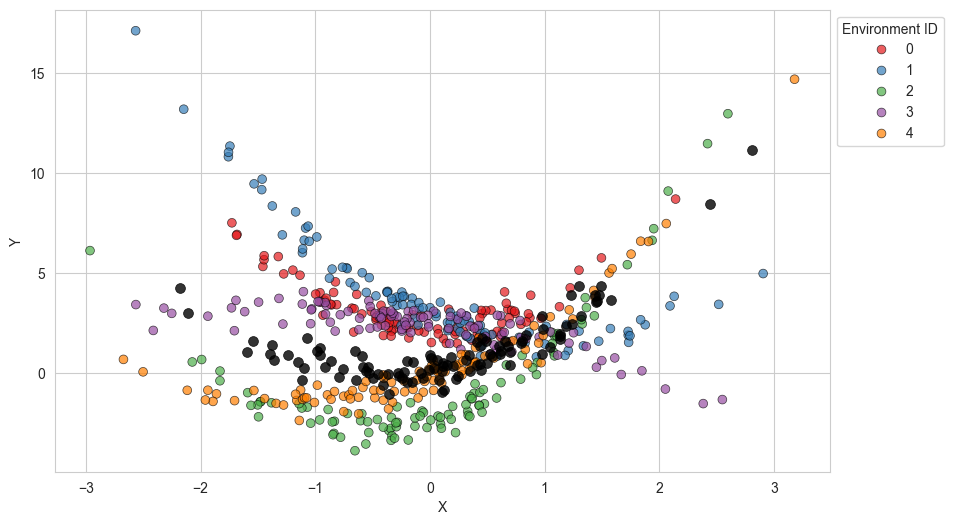

In [24]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dtr, x="X", y="Y", hue="E", palette="Set1",
                alpha=0.7, s=40, edgecolor="black")
sns.scatterplot(data=dts, x="X", y="Y", color="black", 
                alpha=0.8, s=50, edgecolor="black")

plt.legend(title="Environment ID", loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

In [25]:
m_try = 1.0
rf = MaggingRF(n_estimators=50, random_state=42, max_features=m_try)
rf.fit(Xtr, Ytr)

MaggingRF()

In [26]:
preds = rf.predict(Xts)
wpreds, weights = rf.predict_maximin(Xtr, Xts)

In [27]:
mean_squared_error(Yts, wpreds), r2_score(Yts, wpreds)

(3.9832806342821145, -0.28722681737683264)

In [28]:
mean_squared_error(Yts, preds), r2_score(Yts, preds)

(3.596836690490757, -0.16234457745131148)

### Test distribution outside the convex hull of the train distributions

In [29]:
dtr, dts = gen_data(inhull=False)
Xtr, Xts = np.array(dtr.drop(columns=['E', 'Y'])), np.array(dts.drop(columns=['E', 'Y']))
Ytr, Yts = np.array(dtr['Y']), np.array(dts['Y'])
Etr = np.array(dtr['E'])

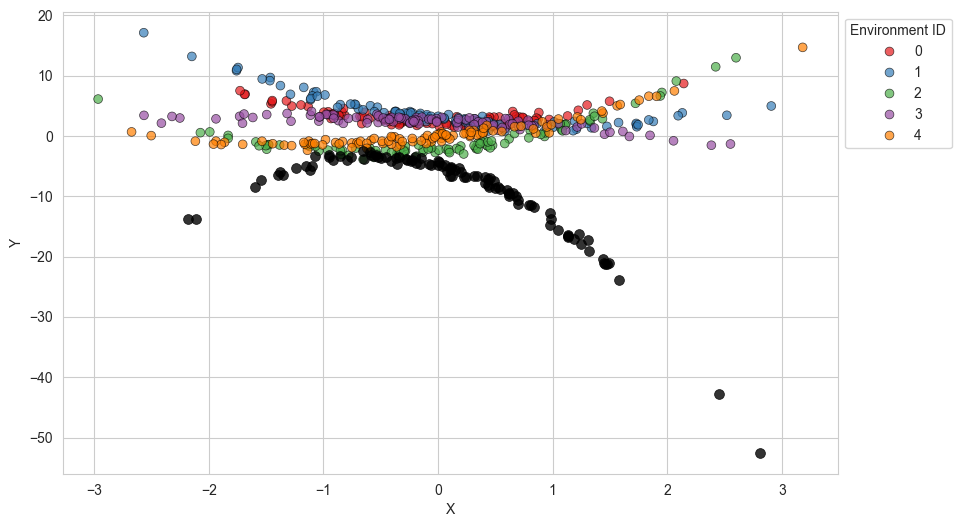

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dtr, x="X", y="Y", hue="E", palette="Set1",
                alpha=0.7, s=40, edgecolor="black")
sns.scatterplot(data=dts, x="X", y="Y", color="black", 
                alpha=0.8, s=50, edgecolor="black")

plt.legend(title="Environment ID", loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

In [31]:
m_try = 1.0
rf = MaggingRF(n_estimators=50, random_state=42, max_features=m_try)
rf.fit(Xtr, Ytr)

MaggingRF()

In [32]:
preds = rf.predict(Xts)
wpreds, weights = rf.predict_maximin(Xtr, Xts)

In [33]:
mean_squared_error(Yts, wpreds), r2_score(Yts, wpreds)

(187.68142676353165, -2.197166016588613)

In [34]:
mean_squared_error(Yts, preds), r2_score(Yts, preds)

(191.59248329353687, -2.2637911336410554)

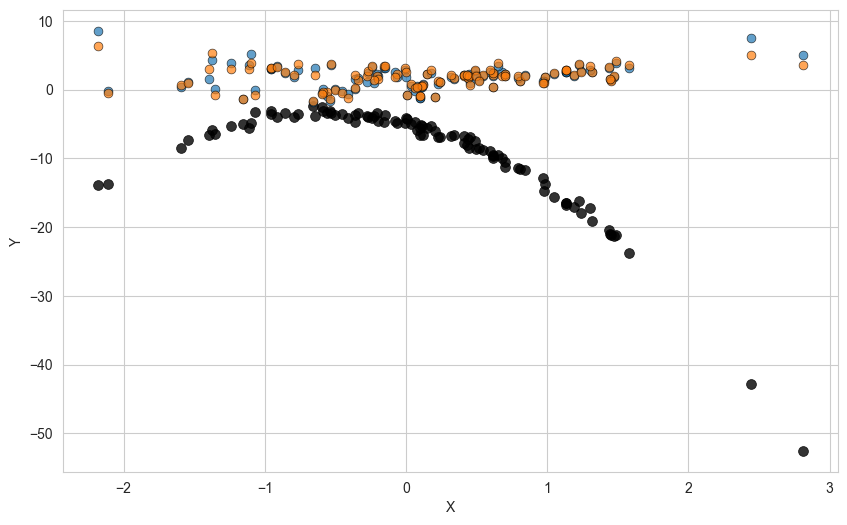

In [35]:
plt.figure(figsize=(10, 6))
dpr = pd.DataFrame({"X": Xts.ravel(), "Y": preds})
dwpr = pd.DataFrame({"X": Xts.ravel(), "Y": wpreds})
sns.scatterplot(data=dts, x="X", y="Y", color="black", 
                alpha=0.8, s=50, edgecolor="black")
sns.scatterplot(data=dpr, x="X", y="Y", color="#1f77b4",
                alpha=0.7, s=40, edgecolor="black")
sns.scatterplot(data=dwpr, x="X", y="Y", color="#ff7f0e",
                alpha=0.7, s=40, edgecolor="black")

plt.grid(True)
plt.show()

## Solution 2: Gaussian Process Regression

In [36]:
dtr, dts = gen_data_v2(n_train=1000, n_test=500)
Xtr, Xts = np.array(dtr.drop(columns=['E', 'Y'])), np.array(dts.drop(columns=['E', 'Y']))
Ytr, Yts = np.array(dtr['Y']), np.array(dts['Y'])
Etr = np.array(dtr['E'])

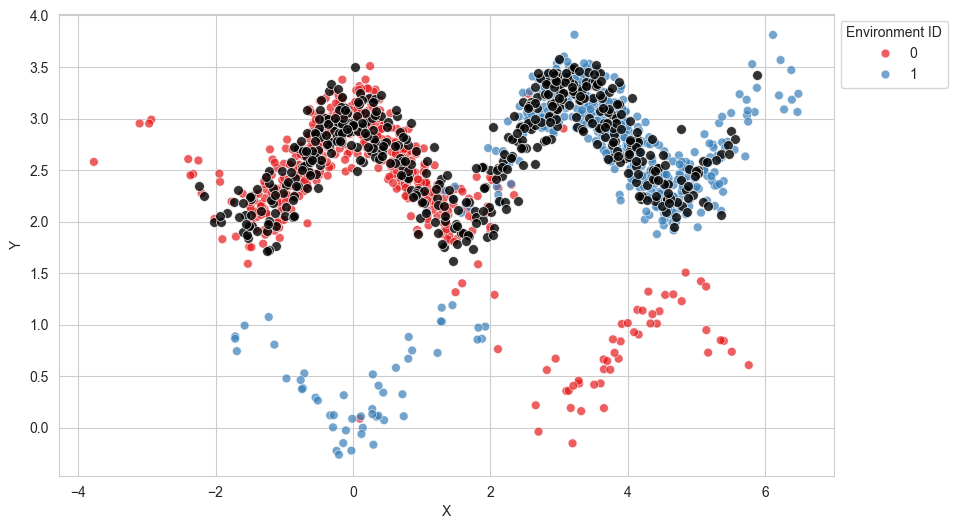

In [37]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dtr, x="X", y="Y", hue="E", palette="Set1", alpha=0.7, s=40)
sns.scatterplot(data=dts, x="X", y="Y", color="black", alpha=0.8, s=50)

plt.legend(title="Environment ID", loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

### Maximin GPR

In [38]:
kernel = ConstantKernel() * RBF(length_scale=1.0) + ConstantKernel() * WhiteKernel(noise_level=1.0)
mgpr = MaximinGPR(kernel=kernel)
mgpr.fit(Xtr, Etr, Ytr)
Xtr_sorted = np.sort(Xtr, axis=0)
Xts_sorted = np.sort(Xts, axis=0)
mpreds = mgpr.predict(Xts)
mfitted = mgpr.predict(Xtr)

### Default GPR

In [39]:
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(Xtr, Ytr)
preds = gp.predict(Xts)
fitted = gp.predict(Xtr)

### Magging GPR

In [40]:
def objective(w: np.ndarray, F: np.ndarray) -> float:
    return np.dot(w.T, np.dot(F.T, F).dot(w))

n_envs = len(np.unique(Etr))
winit = np.array([1 / n_envs] * n_envs)
constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
bounds = [[0, 1] for _ in range(n_envs)]

preds_envs = []
fitted_envs = []
for env in np.unique(Etr):
    Xtr_e = Xtr[Etr == env]
    Ytr_e = Ytr[Etr == env]
    gpr = GaussianProcessRegressor(kernel=kernel)
    gpr.fit(Xtr_e, Ytr_e)
    preds_envs.append(gpr.predict(Xts_sorted))
    fitted_envs.append(gpr.predict(Xtr_sorted))
preds_envs = np.column_stack(preds_envs)
fitted_envs = np.column_stack(fitted_envs)

wmag = minimize(objective, winit, args=(fitted_envs,), bounds=bounds, constraints=constraints,).x
wpreds = np.dot(wmag, preds_envs.T)
wfitted = np.dot(wmag, fitted_envs.T)

In [41]:
dtr["X_sorted"] = Xtr_sorted
dts["X_sorted"] = Xts_sorted
dtr["mfitted"], dtr["fitted_mstd"] = mgpr.predict(Xtr_sorted, return_std=True)
dtr["fitted"], dtr["fitted_std"] = gp.predict(Xtr_sorted, return_std=True)
dts["mpreds"], dts["preds_mstd"] = mgpr.predict(Xts_sorted, return_std=True)
dts["preds"], dts["preds_std"] = gp.predict(Xts_sorted, return_std=True)
dtr["wfitted"] = wfitted
dts["wpreds"] = wpreds

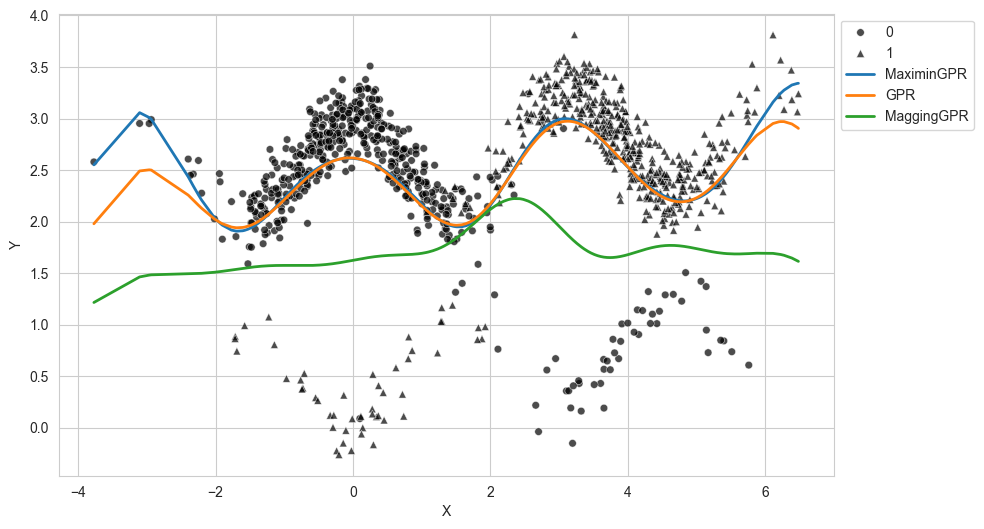

In [42]:
plt.figure(figsize=(10, 6))

scatter = sns.scatterplot(data=dtr, x="X", y="Y", style="E", markers=['o', '^'], alpha=0.7, s=30, color='black')

line1, = plt.plot(dtr["X_sorted"], dtr["mfitted"], linewidth=2, label="MaximinGPR")
line2, = plt.plot(dtr["X_sorted"], dtr["fitted"], linewidth=2, label="GPR")
line3, = plt.plot(dtr["X_sorted"], dtr["wfitted"], linewidth=2, label="MaggingGPR")

handles, labels = scatter.get_legend_handles_labels()
method_legend = [line1, line2, line3]

plt.legend(handles=handles + method_legend, labels=labels, loc="upper left", bbox_to_anchor=(1, 1))

plt.grid(True)
plt.show()

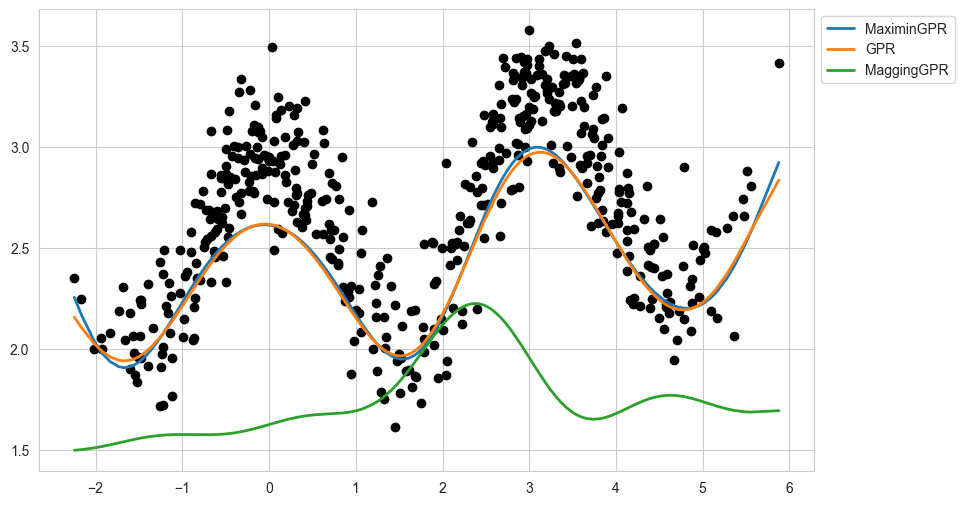

In [43]:
plt.figure(figsize=(10, 6))
plt.scatter(dts["X"], dts["Y"], color="black")
line1, = plt.plot(dts["X_sorted"], dts["mpreds"], linewidth=2, label="MaximinGPR")
line2, = plt.plot(dts["X_sorted"], dts["preds"], linewidth=2, label="GPR")
line3, = plt.plot(dts["X_sorted"], dts["wpreds"], linewidth=2, label="MaggingGPR")

method_legend = [line1, line2, line3]

plt.legend(handles=method_legend, loc="upper left", bbox_to_anchor=(1, 1))

plt.grid(True)
plt.show()

## Solution 3: Neural Networks

In [44]:
dtr, dts = gen_data_v2(n_train=1000, n_test=500)
Xtr, Xts = np.array(dtr.drop(columns=['E', 'Y'])), np.array(dts.drop(columns=['E', 'Y']))
Ytr, Yts = np.array(dtr['Y']), np.array(dts['Y'])
Etr = np.array(dtr['E'])

In [45]:
scaler = StandardScaler()
X_train = scaler.fit_transform(Xtr)
X_test = scaler.transform(Xts)
X_train_sorted = np.sort(X_train, axis=0)
X_test_sorted = np.sort(X_test, axis=0)
X_train_tensor = torch.tensor(X_train_sorted, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_sorted, dtype=torch.float32)

### Maximin NN

In [46]:
model = train_model(X_train, Ytr, Etr, epochs=200, verbose=False)
with torch.no_grad():
    mpreds = model(X_test_tensor).numpy()
    mfitted = model(X_train_tensor).numpy()

### Default NN

In [47]:
model = train_model(X_train, Ytr, Etr, epochs=200, verbose=False, default=True)
with torch.no_grad():
    preds = model(X_test_tensor).numpy()
    fitted = model(X_train_tensor).numpy()

### Magging NN

In [48]:
def objective(w: np.ndarray, F: np.ndarray) -> float:
    return np.dot(w.T, np.dot(F.T, F).dot(w))

n_envs = len(np.unique(Etr))
winit = np.array([1 / n_envs] * n_envs)
constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
bounds = [[0, 1] for _ in range(n_envs)]

preds_envs = []
fitted_envs = []
for env in np.unique(Etr):
    Xtr_e = X_train[Etr == env]
    Ytr_e = Ytr[Etr == env]
    model = train_model(Xtr_e, Ytr_e, Etr[Etr == env], epochs=200, verbose=False, default=True)
    with torch.no_grad():
        preds_envs.append(model(X_test_tensor).numpy())
        fitted_envs.append(model(X_train_tensor).numpy())
preds_envs = np.column_stack(preds_envs)
fitted_envs = np.column_stack(fitted_envs)

wmag = minimize(objective, winit, args=(fitted_envs,), bounds=bounds, constraints=constraints,).x
wpreds = np.dot(wmag, preds_envs.T)
wfitted = np.dot(wmag, fitted_envs.T)

In [49]:
dtr["X_transf"] = X_train
dts["X_transf"] = X_test
dtr["X_sorted"] = X_train_sorted.ravel()
dts["X_sorted"] = X_test_sorted.ravel()
dtr["mfitted"] = mfitted
dtr["fitted"] = fitted
dts["mpreds"] = mpreds
dts["preds"] = preds
dtr["wfitted"] = wfitted
dts["wpreds"] = wpreds

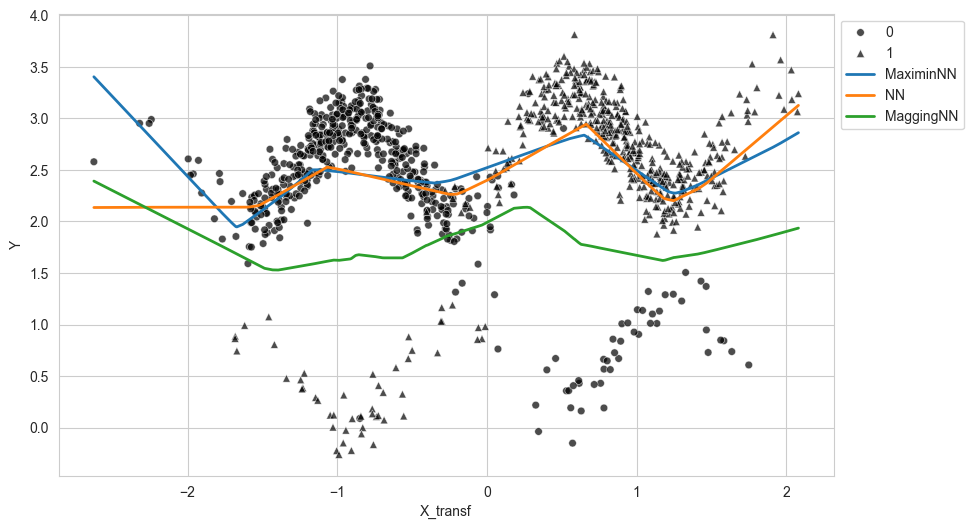

In [50]:
plt.figure(figsize=(10, 6))

scatter = sns.scatterplot(data=dtr, x="X_transf", y="Y", style="E", markers=['o', '^'], alpha=0.7, s=30, color='black')

line1, = plt.plot(dtr["X_sorted"], dtr["mfitted"], linewidth=2, label="MaximinNN")
line2, = plt.plot(dtr["X_sorted"], dtr["fitted"], linewidth=2, label="NN")
line3, = plt.plot(dtr["X_sorted"], dtr["wfitted"], linewidth=2, label="MaggingNN")

handles, labels = scatter.get_legend_handles_labels()
method_legend = [line1, line2, line3]
method_legend = [line1, line2]

plt.legend(handles=handles + method_legend, labels=labels, loc="upper left", bbox_to_anchor=(1, 1))

plt.grid(True)
plt.show()

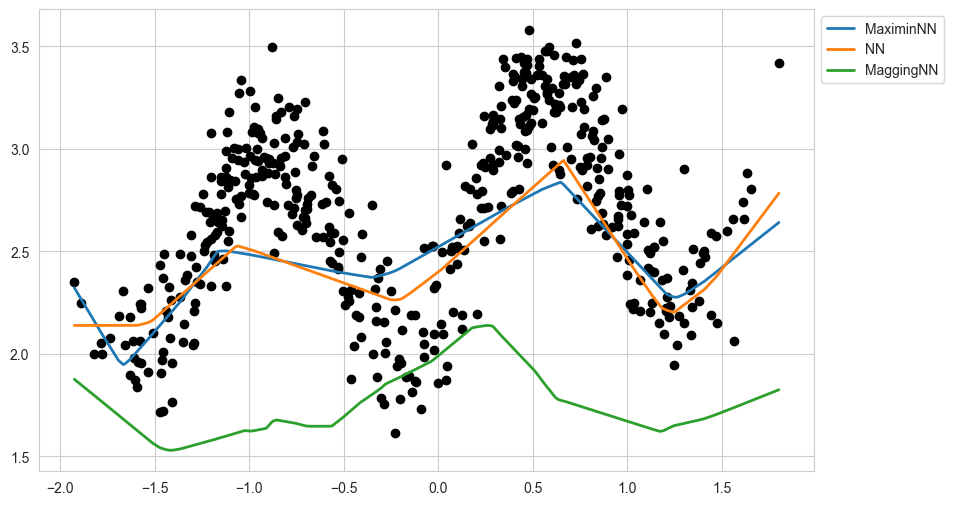

In [51]:
plt.figure(figsize=(10, 6))
plt.scatter(dts["X_transf"], dts["Y"], color="black")
line1, = plt.plot(dts["X_sorted"], dts["mpreds"], linewidth=2, label="MaximinNN")
line2, = plt.plot(dts["X_sorted"], dts["preds"], linewidth=2, label="NN")
line3, = plt.plot(dts["X_sorted"], dts["wpreds"], linewidth=2, label="MaggingNN")

method_legend = [line1, line2, line3]

plt.legend(handles=method_legend, loc="upper left", bbox_to_anchor=(1, 1))

plt.grid(True)
plt.show()

## Solution 4: Modifying the splitting criterion

In [2]:
dtr, dts = gen_data_v2(n_train=1000, n_test=500)
Xtr, Xts = np.array(dtr.drop(columns=['E', 'Y'])), np.array(dts.drop(columns=['E', 'Y']))
Ytr, Yts = np.array(dtr['Y']), np.array(dts['Y'])
Etr = np.array(dtr['E'])

### Maximin RF

In [3]:
mrf = RF4DL(criterion='maximin', n_estimators=50, min_samples_leaf=10)
mrf.fit(Xtr, Ytr, Etr)
Xtr_sorted = np.sort(Xtr, axis=0)
Xts_sorted = np.sort(Xts, axis=0)
mpreds = mrf.predict(Xts_sorted)
mfitted = mrf.predict(Xtr_sorted)

100%|██████████| 50/50 [01:29<00:00,  1.80s/it]


### Default RF

In [4]:
rf = RF4DL(criterion='mse', n_estimators=50, min_samples_leaf=10)
rf.fit(Xtr, Ytr, Etr)
preds = rf.predict(Xts_sorted)
fitted = rf.predict(Xtr_sorted)

100%|██████████| 50/50 [00:18<00:00,  2.68it/s]


### Magging RF

In [5]:
def objective(w: np.ndarray, F: np.ndarray) -> float:
    return np.dot(w.T, np.dot(F.T, F).dot(w))

n_envs = len(np.unique(Etr))
winit = np.array([1 / n_envs] * n_envs)
constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
bounds = [[0, 1] for _ in range(n_envs)]

preds_envs = []
fitted_envs = []
for env in np.unique(Etr):
    Xtr_e = Xtr[Etr == env]
    Ytr_e = Ytr[Etr == env]
    Etr_e = Etr[Etr == env]
    rfm = RF4DL(criterion='mse', n_estimators=50, min_samples_leaf=10)
    rfm.fit(Xtr_e, Ytr_e, Etr_e)
    preds_envs.append(rfm.predict(Xts_sorted))
    fitted_envs.append(rfm.predict(Xtr_sorted))
preds_envs = np.column_stack(preds_envs)
fitted_envs = np.column_stack(fitted_envs)

wmag = minimize(objective, winit, args=(fitted_envs,), bounds=bounds, constraints=constraints,).x
wpreds = np.dot(wmag, preds_envs.T)
wfitted = np.dot(wmag, fitted_envs.T)

100%|██████████| 50/50 [00:07<00:00,  7.04it/s]


### Magging RF 2

In [6]:
rfm2 = MaggingRF(n_estimators=50, min_samples_leaf=10)
rfm2.fit(Xtr, Ytr)
wpreds2 = rfm2.predict(Xts_sorted)
wfitted2 = rfm2.predict(Xtr_sorted)

In [7]:
dtr["X_sorted"] = Xtr_sorted
dts["X_sorted"] = Xts_sorted
dtr["mfitted"] = mfitted
dtr["fitted"] = fitted
dts["mpreds"] = mpreds
dts["preds"] = preds
dtr["wfitted"] = wfitted
dts["wpreds"] = wpreds
dtr["wfitted2"] = wfitted2
dts["wpreds2"] = wpreds2

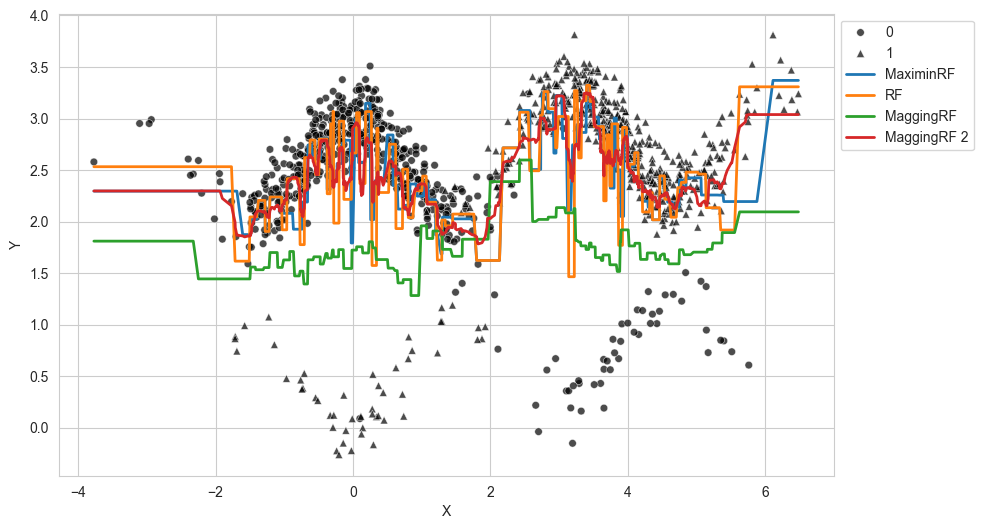

In [8]:
plt.figure(figsize=(10, 6))

scatter = sns.scatterplot(data=dtr, x="X", y="Y", style="E", markers=['o', '^'], alpha=0.7, s=30, color='black')

line1, = plt.plot(dtr["X_sorted"], dtr["mfitted"], linewidth=2, label="MaximinRF")
line2, = plt.plot(dtr["X_sorted"], dtr["fitted"], linewidth=2, label="RF")
line3, = plt.plot(dtr["X_sorted"], dtr["wfitted"], linewidth=2, label="MaggingRF")
line4, = plt.plot(dtr["X_sorted"], dtr["wfitted2"], linewidth=2, label="MaggingRF 2")

handles, labels = scatter.get_legend_handles_labels()
method_legend = [line1, line2, line3, line4]

plt.legend(handles=handles + method_legend, labels=labels, loc="upper left", bbox_to_anchor=(1, 1))

plt.grid(True)
plt.show()

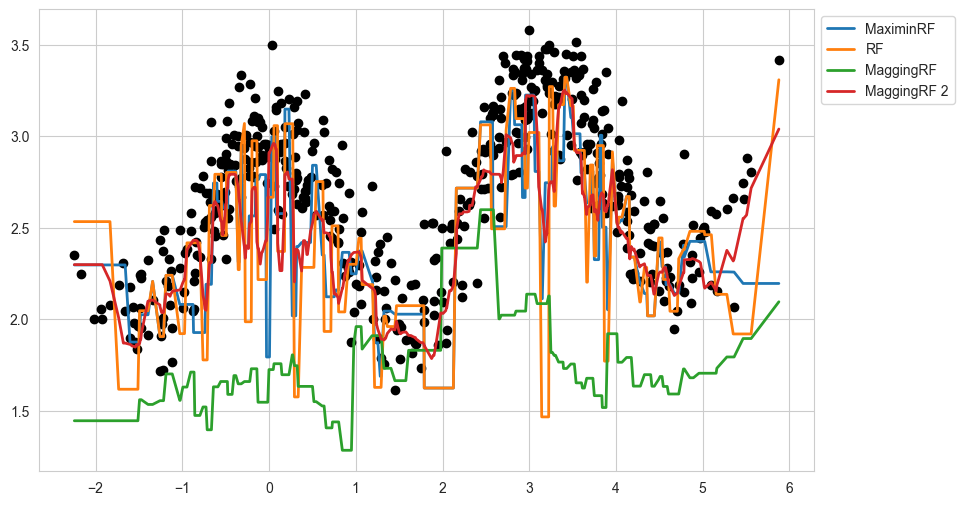

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(dts["X"], dts["Y"], color="black")
line1, = plt.plot(dts["X_sorted"], dts["mpreds"], linewidth=2, label="MaximinRF")
line2, = plt.plot(dts["X_sorted"], dts["preds"], linewidth=2, label="RF")
line3, = plt.plot(dts["X_sorted"], dts["wpreds"], linewidth=2, label="MaggingRF")
line4, = plt.plot(dts["X_sorted"], dts["wpreds2"], linewidth=2, label="MaggingRF 2")

method_legend = [line1, line2, line3, line4]

plt.legend(handles=method_legend, loc="upper left", bbox_to_anchor=(1, 1))

plt.grid(True)
plt.show()

## Different data setting

In [10]:
dtr, dts = gen_data_v3(n_train=1000, n_test=500)
Xtr, Xts = np.array(dtr.drop(columns=['E', 'Y'])), np.array(dts.drop(columns=['E', 'Y']))
Ytr, Yts = np.array(dtr['Y']), np.array(dts['Y'])
Etr = np.array(dtr['E'])

### Maximin RF

In [11]:
mrf = RF4DL(criterion='maximin', n_estimators=50, min_samples_leaf=10)
mrf.fit(Xtr, Ytr, Etr)
mpreds = mrf.predict(Xts)
mfitted = mrf.predict(Xtr)

100%|██████████| 50/50 [02:24<00:00,  2.90s/it]


In [12]:
mean_squared_error(Ytr, mfitted), r2_score(Ytr, mfitted)

(3.7377706105721535, 0.7363498774065744)

In [13]:
mean_squared_error(Yts, mpreds), r2_score(Yts, mpreds)

(1.970197090821492, 0.8364270667278179)

In [14]:
max_mse(Ytr, mfitted, Etr)

np.float64(4.886644387522157)

### Default RF

In [15]:
rf = RF4DL(criterion='mse', n_estimators=50, min_samples_leaf=10)
rf.fit(Xtr, Ytr, Etr)
preds = rf.predict(Xts)
fitted = rf.predict(Xtr)

100%|██████████| 50/50 [00:41<00:00,  1.22it/s]


In [16]:
mean_squared_error(Ytr, fitted), r2_score(Ytr, fitted)

(3.4170781776355836, 0.7589704734964902)

In [17]:
mean_squared_error(Yts, preds), r2_score(Yts, preds)

(2.5055575701402133, 0.7919794912196989)

In [18]:
max_mse(Ytr, fitted, Etr)

np.float64(4.248715785284313)

### Magging RF

In [19]:
def objective(w: np.ndarray, F: np.ndarray) -> float:
    return np.dot(w.T, np.dot(F.T, F).dot(w))

n_envs = len(np.unique(Etr))
winit = np.array([1 / n_envs] * n_envs)
constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
bounds = [[0, 1] for _ in range(n_envs)]

preds_envs = []
fitted_envs = []
for env in np.unique(Etr):
    Xtr_e = Xtr[Etr == env]
    Ytr_e = Ytr[Etr == env]
    Etr_e = Etr[Etr == env]
    rfm = RF4DL(criterion='mse', n_estimators=50, min_samples_leaf=10)
    rfm.fit(Xtr_e, Ytr_e, Etr_e)
    preds_envs.append(rfm.predict(Xts))
    fitted_envs.append(rfm.predict(Xtr))
preds_envs = np.column_stack(preds_envs)
fitted_envs = np.column_stack(fitted_envs)

wmag = minimize(objective, winit, args=(fitted_envs,), bounds=bounds, constraints=constraints,).x
wpreds = np.dot(wmag, preds_envs.T)
wfitted = np.dot(wmag, fitted_envs.T)

100%|██████████| 50/50 [00:08<00:00,  6.08it/s]


In [20]:
mean_squared_error(Ytr, wfitted), r2_score(Ytr, wfitted)

(4.212410951764907, 0.7028702990211851)

In [21]:
mean_squared_error(Yts, wpreds), r2_score(Yts, wpreds)

(1.5337615012581116, 0.872661537838264)

If you look at the weights, it finds basically a convex combination of the first and second environment, which gives the test set, because if you add them they nullify each other.

In [22]:
wmag

array([5.17574560e-01, 4.82425440e-01, 7.39659143e-12])

In [23]:
max_mse(Ytr, wfitted, Etr)

np.float64(4.874322789910498)

### Magging RF 2

Maybe unfair comparison because it uses Random Forest from sklearn.

In [24]:
rfm2 = MaggingRF(n_estimators=50, min_samples_leaf=10)
rfm2.fit(Xtr, Ytr)
wpreds2 = rfm2.predict(Xts)
wfitted2 = rfm2.predict(Xtr)

In [25]:
mean_squared_error(Ytr, wfitted2), r2_score(Ytr, wfitted2)

(2.902371541008695, 0.7952761974118367)

In [26]:
mean_squared_error(Yts, wpreds2), r2_score(Yts, wpreds2)

(1.4195279460919683, 0.8821456233562487)

In [27]:
max_mse(Ytr, wfitted2, Etr)

np.float64(3.7265151750012917)